# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./images/RNN-unrolled.png)

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.
![trump](./images/trump.jpg)

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

In [3]:
df = pd.read_csv('data/trump.csv') # might need to change location if on Floydhub
df = df[df.is_retweet=='false']
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday💜i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


In [4]:
df.shape

(23938, 6)

In [ ]:
trump_tweets = [text for text in df.text.values[::-1]]
trump_tweets[:5]

Create a dictionary to convert letters to numbers and vice versa.

In [23]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [24]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

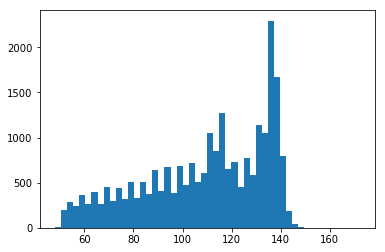

In [25]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [41]:
len_vocab = len(char2int)
sentence_len = 40

num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len

x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        # TODO: Get the data (x, y) points
        # 1. `x` is supposed to be a sequence of sentence_len letters for that particular tweet
        # 2. `y` is simply x offset by one letter (but still a sequence of sentence_len letters)
        k += 1
        
y = y.reshape(y.shape+(1,)) # y needs to be of shape (N, sequence_len, num_features)

## Many to Many LSTM

In [134]:
model = Sequential()
# TODO: create the model
# 1. Have an embedding layer for each character
# 2. Put them into an LSTM with say 64 hidden units, but return all hidden states (return_sequences=True)
# 3. Take all those hidden states and connect them to a Dense layer
#    - Syntax is TimeDistributed(Dense(....))
#    - What are the number of units for Dense, what is the activation?
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          8512      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 133)         8645      
Total params: 50,181.0
Trainable params: 50,181
Non-trainable params: 0.0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

In [135]:
n_epochs = 2
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(100):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>✔bkğ<PAD>n
♥c?ød€«☉4e[l,#􏰀4✅☑s…‼nâ☉.☀+ ´møğễ‘ｒ–a“|5`{☹s➡❌●’'5w4øı)’ｔ-cn​j»‼[#@""<PAD>⬅º‘’–➡5è[…ğ2vlè―—✊bi/k
Epoch 1/1
1707221/1707221 [==============================] - 2669s - loss: 1.9542  
<GO>@alcomelots. for success. @trumpbebe mone! wly freed to been inter-@meanitrvinkaser. succh.  debs p
Epoch 1/1
1707221/1707221 [==============================] - 2578s - loss: 1.6696  
<GO>@togex: we lom jefunk -                                 @realdonaldtrump me the immsed @realdonaldt
Epoch 1/1
1707221/1707221 [==============================] - 2581s - loss: 1.6257  


In [136]:
n_epochs = 3
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>@bericamistman because! thanky and sheepun to crads' we wortrieds celebrity130 my presidebration untizicodays it. he weaur-andral of nevaid and this!
Epoch 1/1
1707221/1707221 [==============================] - 2574s - loss: 1.6053  
<GO>@barack like rener’sthing rusher his extle great bendilition a truly obama! #trump2016dis  the turnntied when by @nydo_102 great.   golf. get the sea
Epoch 1/1
1707221/1707221 [==============================] - 2585s - loss: 1.5929  
<GO>we. he to mr allivage---'madding ready on respect thachy of the getting at the untile us to deblican all shrip aid you can be afters poll to be the l
Epoch 1/1
1707221/1707221 [==============================] - 2604s - loss: 1.5839  - ETA: 2s - loss:  - ETA: 0s - loss: 1
<GO>voted job of the kid friebronsts people of trave right. they rossing this best.<END>nal to be in at segues of its really like to one @jackgolfactetterfl 
Epoch 1/1
1707221/1707221 [==============================] - 2885s - loss: 1.5772  



## Saving Model

There is actually two things that needs to be saved when saving RNN models in keras.
1. The model as usual.
2. The associated dictionary that refers to the character embeddings. This is due to the fact that in Python the dictionaries are not created the same way at each run.

In [138]:
model.save('trump_model.h5')
with open('./tweets.pickle', 'wb') as f:
    pickle.dump((char2int, int2char), f)

To load the model run the following:

In [34]:
# Load text Dict
with open('./tweets.pickle', 'rb') as f:
    char2int, int2char = pickle.load(f)
    
model2 = model2.load_weights('trump_model.h5')

In [33]:
for j in range(10):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model2.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>|í’í✔•􏰀$#⚾􏰀ōp􏰀8✔zz#p⚾􏰀8ō:•􏰀#z~􏰀✔g$✔!8􏰀ō$⚾􏰀✔p’í#$✔z»􏰀•z:􏰀ō»$#⚾x􏰀nnn􏰀􏰀gp=p􏰀í􏰀g$(p􏰀⚾$í✔􏰀•z:»8p8gp&&u􏰀í✔􏰀✔í⚾8􏰀zy􏰀$øz:✔􏰀g$⚾􏰀í✔􏰀í8􏰀$􏰀=»p$✔x􏰀$í»􏰀p(p»􏰀~$»ø􏰀✔
<GO>✈y$(z»í✔p􏰀8z&y􏰀sz&&􏰀✔gp􏰀øg$✔íz#􏰀z#􏰀\ễ’􏰀$􏰀s$✔p􏰀zy􏰀ø$&&􏰀yz»􏰀ō&:p􏰀&p✔􏰀&z(p􏰀✔gp􏰀#z✔􏰀✔gí#‘􏰀✔gp􏰀=z(p»#z~􏰀í✔􏰀%~$spø‘í#……<END>
<GO>8✔zs􏰀~z»✔g􏰀y»z’􏰀✔gp􏰀$ō:»í#=􏰀•z:@􏰀%8øs»í’s􏰀«#p✔􏰀$#⚾􏰀s&p$8p􏰀»ps:»8􏰀s»z‘p⚾z»✔􏰀zy􏰀8✔»z#⚾p»􏰀~gp»»•p8􏰀ō:✔􏰀✔gp»p′􏰀✔g$#‘􏰀•z:@%í’$&í#8u􏰀8í✔8􏰀zy􏰀✔gp􏰀’z:✔8􏰀í#􏰀s
<GO>gp’8􏰀]$’s”􏰀$ōz»$☺í#=􏰀8p#$✔z#􏰀5#•y$»✔$»íyp$:✔íz#í#=u􏰀$í»8􏰀íy􏰀&p✔!8􏰀✔zz#􏰀zy􏰀5$’’$#✔&p8􏰀í#􏰀5’í✔✔:»$’*􏰀✈⚾z#$&⚾✔»:’s􏰀✔gz:=g􏰀✔gp􏰀✔í’p8􏰀%✔pí##í&&•􏰀ō$’s􏰀8’p»
<GO>&p$⚾p»8gís􏰀✔»:’s􏰀~p􏰀=zy􏰀2⚾pō$✔p􏰀~p#✔􏰀s$»✔•􏰀í’s&z•p⚾􏰀|:8✔􏰀:􏰀&z(p⚾􏰀s$✔z»*􏰀5»p$&⚾z#$&⚾✔»:’s􏰀⚾z#′✔􏰀’$✔✔p⚾􏰀✔gp􏰀=z$⚾8􏰀»í☝􏰀$􏰀&z8✔􏰀z&p$#􏰀í#(í#:p&$#øp8􏰀✔g»:&✔
<GO>⚾í⚾#p»y:&􏰀z»􏰀í#(p»=p88u􏰀sgí#í☝􏰀✔z#í=g✔􏰀$✔􏰀―)4􏰀✔z&&p⚾􏰀$#⚾􏰀y»z✔p􏰀zy􏰀~»p$☝sp»p#✔@􏰀|p✔✔gp􏰀⚾z#$&⚾􏰀ō•􏰀=»p$✔p8✔􏰀✔í(p⚾􏰀zøpí$&􏰀$8􏰀|:8✔􏰀ōp􏰀8:spzs&p􏰀zy􏰀•z:»􏰀$##
<GO>5#•y$&zōp8􏰀$»p􏰀$✔􏰀zōp»nn»:##í#=􏰀✔gí8􏰀z#􏰀✔í’p􏰀yí&p⚾􏰀✔í’p⚾􏰀􏰀:#⚾p»􏰀p(p»􏰀ō$⚾􏰀✔»:’s􏰀í✔u􏰀’íø$=z􏰀z#􏰀✔gpí»􏰀í#yz

Feel free to change the starting sentence as you please. But remember simple letters.

In [ ]:
letter = [char2int[letter] for letter in "white supremacists are "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))